# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

# Loading Data

In [2]:
data = pd.read_csv("SolarPrediction.csv")

In [3]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [5]:
data.shape

(32686, 11)

# Data Wrangling

In [6]:
df = data.copy()

In [7]:
# extract the date from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [8]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [9]:
# extract the date time features from the given parameter using date time python methods
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [10]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [11]:
# extract the sunrise and sunset information using regular expression
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [12]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [14]:
# drop the parameters that are not required after extracting the relevant information
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [15]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [16]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.0,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,10.526066,15.825766,11.557425,27.556691,17.441902,6.0,27.640519,17.347886,37.317904
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,1.096691,8.711824,6.912034,17.268507,12.951109,0.0,15.518714,0.476307,15.938416
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,6.0,7.000000,17.000000,0.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,10.000000,9.000000,6.000000,15.000000,5.000000,6.0,14.000000,17.000000,26.000000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,11.000000,16.000000,12.000000,30.000000,18.000000,6.0,24.000000,17.000000,43.000000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,11.000000,23.000000,18.000000,45.000000,22.000000,6.0,40.000000,18.000000,48.000000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,12.000000,31.000000,23.000000,57.000000,59.000000,6.0,57.000000,18.000000,59.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Radiation               32686 non-null  float64
 1   Temperature             32686 non-null  int64  
 2   Pressure                32686 non-null  float64
 3   Humidity                32686 non-null  int64  
 4   WindDirection(Degrees)  32686 non-null  float64
 5   Speed                   32686 non-null  float64
 6   Month                   32686 non-null  int32  
 7   Day                     32686 non-null  int32  
 8   Hour                    32686 non-null  int32  
 9   Minute                  32686 non-null  int32  
 10  Second                  32686 non-null  int32  
 11  risehour                32686 non-null  int32  
 12  riseminuter             32686 non-null  int32  
 13  sethour                 32686 non-null  int32  
 14  setminute               32686 non-null

In [18]:
df['Month'].unique()

array([ 9, 10, 11, 12])

In [19]:
df.shape

(32686, 15)

In [20]:
# checking the number of null values in the dataset
df.isnull().sum().sum()

0

In [21]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [22]:
# Segragating the input and output features
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

In [23]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [24]:
target.head()

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64

# Feature Extraction

#### Using Correlation Matrix

In [25]:
# extract the correlation between the data features
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


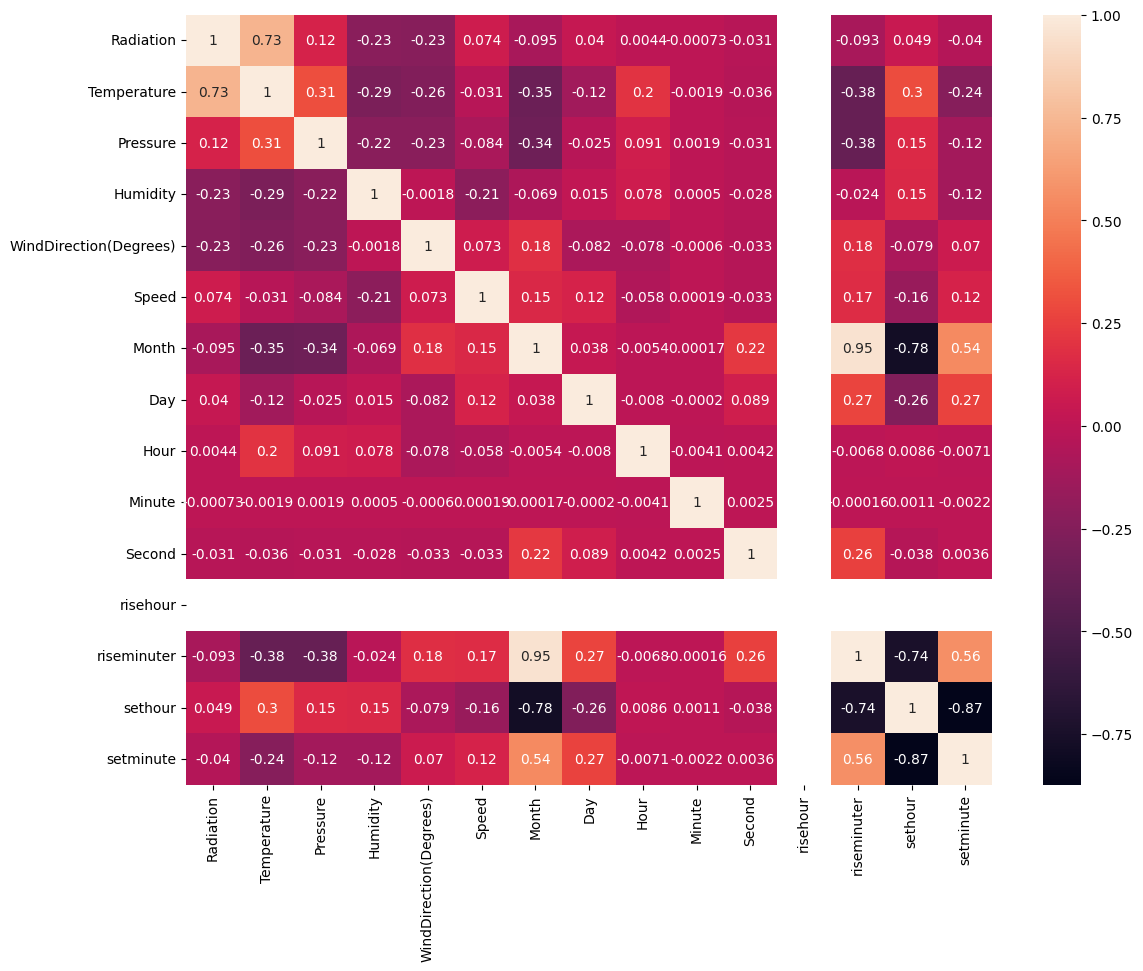

In [26]:
# plot the correlation matrix using heatmap for clear understanding
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

#### Using SelectKBest Method

In [27]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

In [28]:
target_cont = df['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
scaled_Std_input_features = StandardScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [29]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [30]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp']

In [31]:
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


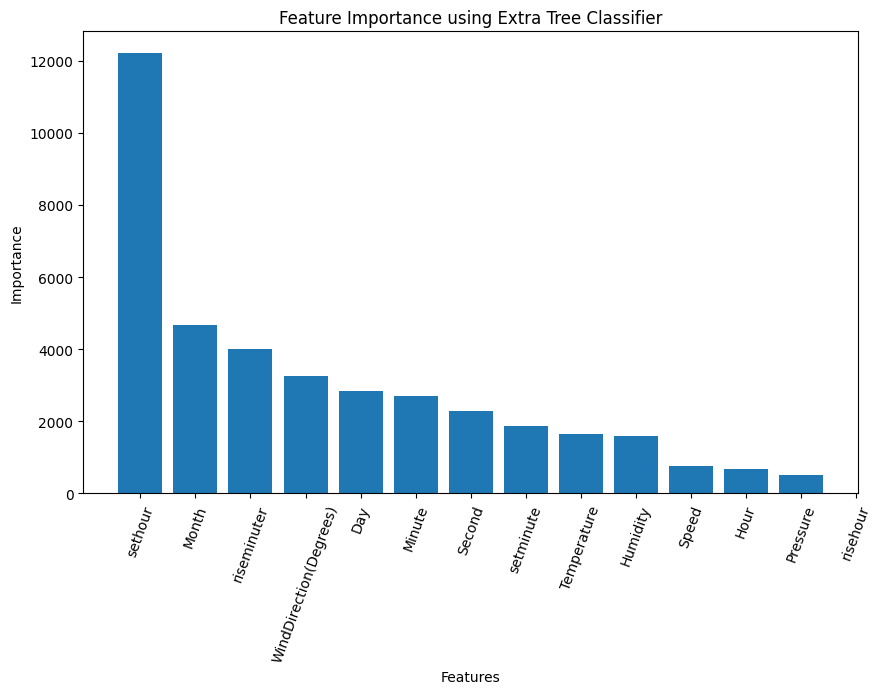

In [32]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

#### Using ExtraTreeClassifier

In [33]:
model = ExtraTreesClassifier(verbose = 2, n_estimators = 1)

In [34]:
model.fit(scaled_input_features, target_cont)

building tree 1 of 1


ExtraTreesClassifier(n_estimators=1, verbose=2)

In [35]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["feature_imp"])
feature_importances.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.158934
Minute,0.150545
Speed,0.125329
Second,0.123304
Humidity,0.108765
Hour,0.092562
Temperature,0.083772
Pressure,0.075377
Day,0.033758
setminute,0.022945


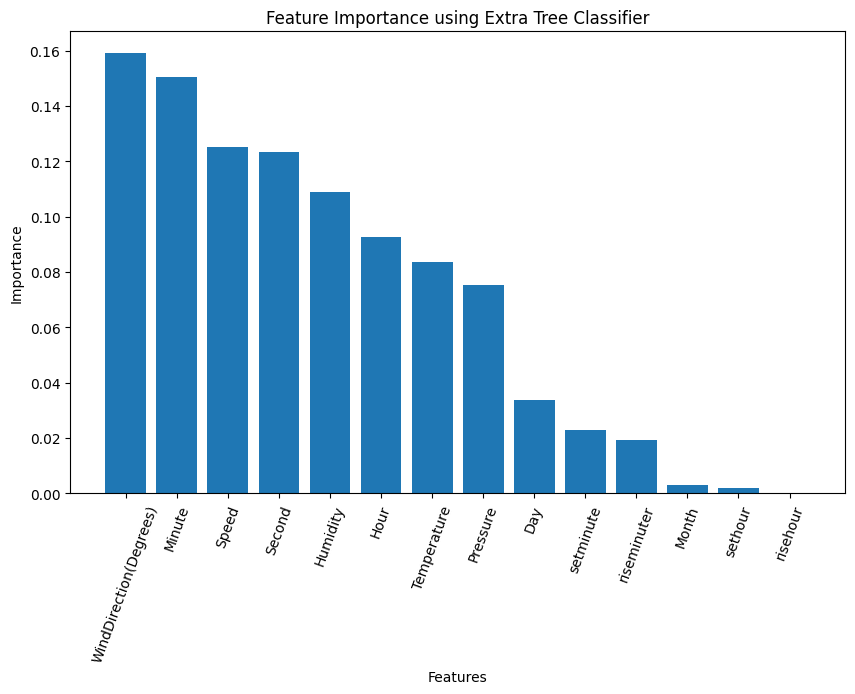

In [36]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importances.index, feature_importances["feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

# Feature Engineering with BoxCox, Log, Min-Max and Standard transformation

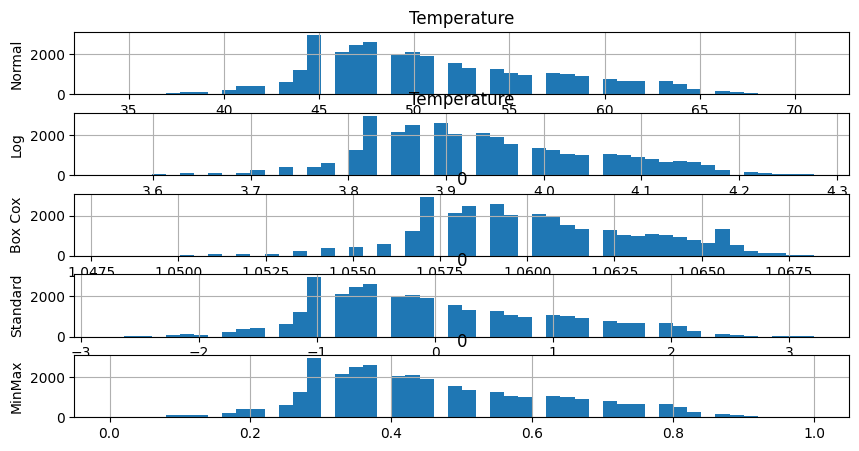

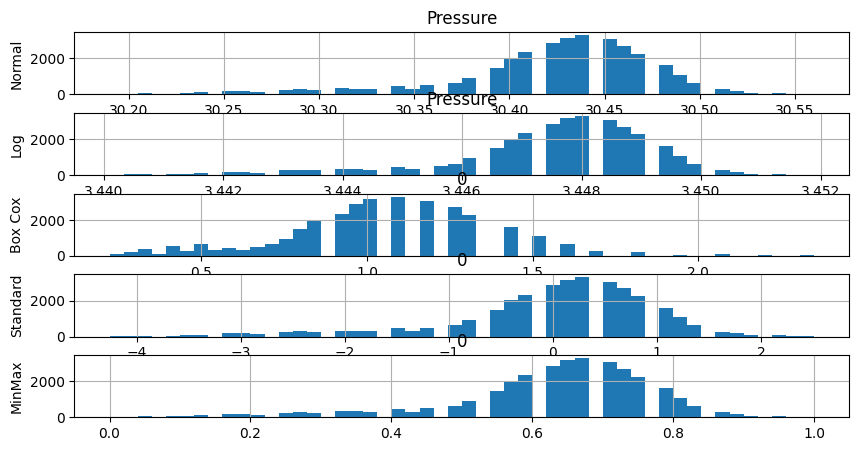

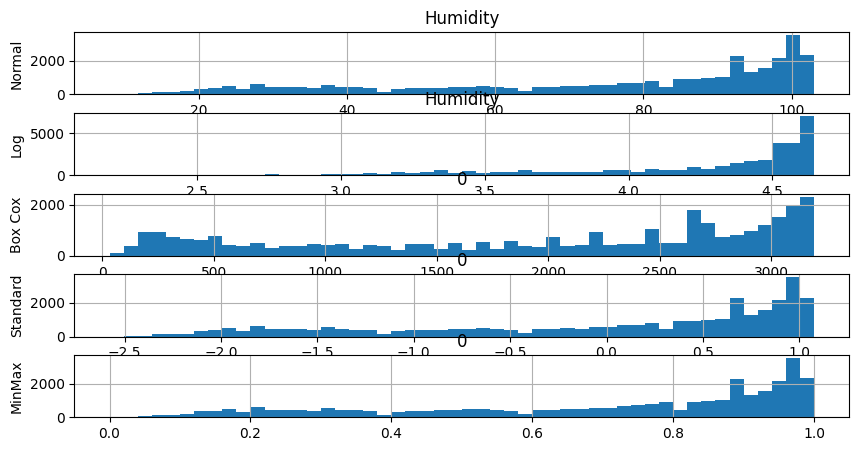

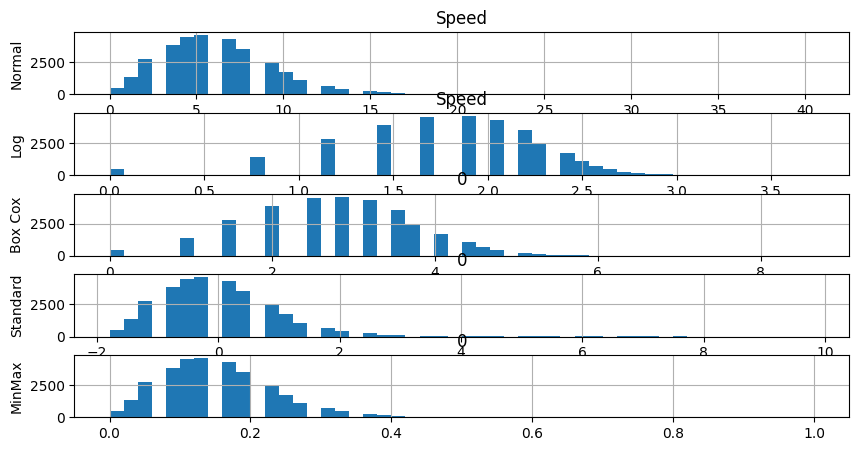

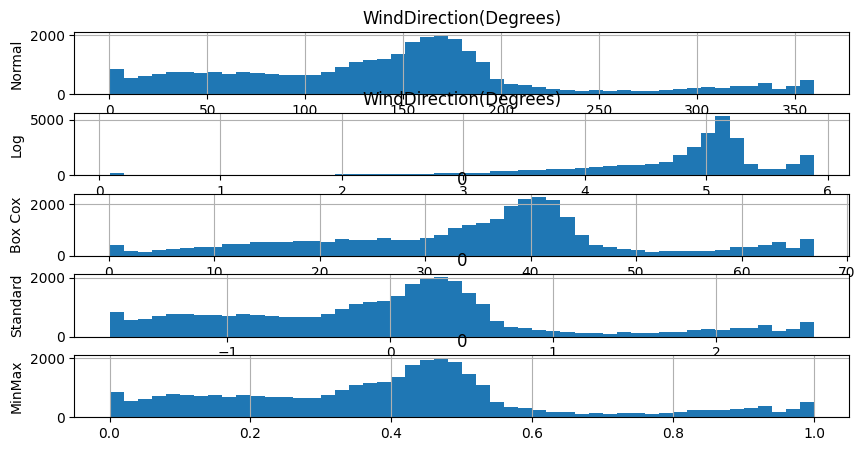

In [37]:
# Looking for transformation
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [38]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
            'Speed' : (input_features['Speed']+1).transform(np.log), 
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [39]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,1.246079e+297,1139.358841,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.246079e+297,1104.047150,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.246079e+297,1069.253710,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,1.246079e+297,1175.187672,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,1.246079e+297,1248.392409,0.291391,1.890095,9,29,23,35,24,6,13,18,13


In [40]:
input_features.describe()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
count,32686.000000,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.0,32686.000000,32686.000000,32686.000000
mean,3.946313,1.037555e+297,1946.794655,0.398488,1.859223,10.526066,15.825766,11.557425,27.556691,17.441902,6.0,27.640519,17.347886,37.317904
std,0.117019,inf,1007.881882,0.231111,0.520981,1.096691,8.711824,6.912034,17.268507,12.951109,0.0,15.518714,0.476307,15.938416
min,3.555348,2.224669e+296,32.143942,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,6.0,7.000000,17.000000,0.000000
25%,3.850148,8.507808e+296,1034.979652,0.228248,1.474763,10.000000,9.000000,6.000000,15.000000,5.000000,6.0,14.000000,17.000000,26.000000
50%,3.931826,1.029725e+297,2236.093233,0.410187,1.890095,11.000000,16.000000,12.000000,30.000000,18.000000,6.0,24.000000,17.000000,43.000000
75%,4.025352,1.246079e+297,2855.773748,0.498027,2.182675,11.000000,23.000000,18.000000,45.000000,22.000000,6.0,40.000000,18.000000,48.000000
max,4.276666,2.349946e+297,3191.915636,1.000000,3.725693,12.000000,31.000000,23.000000,57.000000,59.000000,6.0,57.000000,18.000000,59.000000


# Preparing data - Standardisation and Splitting

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [42]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

In [43]:
xtrain

array([[ 1.40350795,         nan, -0.3335602 , ..., -0.9492458 ,
         1.3799874 , -1.41000176],
       [ 1.26247258,         nan, -0.41513099, ..., -1.0137508 ,
         1.3799874 , -1.41000176],
       [-1.00462526,         nan,  0.69432947, ..., -0.5622158 ,
        -0.7246443 ,  1.10667348],
       ...,
       [ 2.20401138,         nan, -1.81480726, ..., -0.6912258 ,
        -0.7246443 ,  1.35834101],
       [-0.82112473,         nan, -1.23502112, ..., -0.9492458 ,
         1.3799874 , -1.53583553],
       [-1.78083702,         nan,  1.07081702, ...,  1.30842922,
        -0.7246443 ,  0.47750467]])

# Prediction with XGBoost

In [44]:
from sklearn.model_selection import RandomizedSearchCV
# declare parameters
params = {
    'learning_rate': [0.1,0.2,0.3,0.01,0.5],
    'max_depth': [8,10,12,14,15,18,20],
    'n_estimator': [10,20,30,40,50,80,100,200,300,500]
}

from xgboost import XGBRegressor
model = XGBRegressor()
model_cv = RandomizedSearchCV(model, param_distributions= params, cv = 10, random_state = 18)

In [45]:
# train the model
model_cv.fit(xtrain, ytrain)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3, 0.01,
                                                          0.5],
                                        'max_depth': [8, 10, 12, 14, 15, 18,
                                                      20],
                                        'n_estimator': [10, 20, 30, 40, 50, 80,
                                                        100, 200, 300, 500]},
                   random_state=18)

In [46]:
y_pred = model_cv.predict(xtest)

In [47]:
mean_absolute_error(ytest, model_cv.predict(xtest))

30.298703025807367

In [48]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 83.8226


In [49]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 83.82
R2: 0.93


In [50]:
pickle_out=open("SolarXG.pkl","wb")
pickle.dump(model_cv,pickle_out)
pickle_out.close()

# Using Multilayer Perceptron

In [51]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [52]:
model = None
model = Sequential()


model.add(Dense(256, activation='relu', input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3840      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                

In [53]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=100, batch_size=32)

Epoch 1/100


736/736 [==============================] - 13s 11ms/step - loss: 209.5324 - mse: 144868.8438 - val_loss: 203.4936 - val_mse: 136437.6406
Epoch 2/100
736/736 [==============================] - 6s 9ms/step - loss: 208.8369 - mse: 144572.7969 - val_loss: 202.9970 - val_mse: 136213.0781
Epoch 3/100
736/736 [==============================] - 7s 9ms/step - loss: 208.6620 - mse: 144461.2188 - val_loss: 202.9846 - val_mse: 136168.8906
Epoch 4/100
736/736 [==============================] - 6s 9ms/step - loss: 208.6502 - mse: 144410.6562 - val_loss: 202.9695 - val_mse: 136112.1250
Epoch 5/100
736/736 [==============================] - 6s 9ms/step - loss: 208.6364 - mse: 144344.5938 - val_loss: 202.9530 - val_mse: 136043.0781
Epoch 6/100
736/736 [==============================] - 6s 9ms/step - loss: 208.6228 - mse: 144270.4531 - val_loss: 202.9369 - val_mse: 135967.3906
Epoch 7/100
736/736 [==============================] - 6s 9ms/step - loss: 208.6111 - mse: 144197.3750 - val_loss:

736/736 [==============================] - 7s 9ms/step - loss: 208.5914 - mse: 143885.2656 - val_loss: 202.8983 - val_mse: 135632.0156
Epoch 54/100
736/736 [==============================] - 7s 9ms/step - loss: 208.5914 - mse: 143881.7500 - val_loss: 202.8983 - val_mse: 135631.0938
Epoch 55/100
736/736 [==============================] - 6s 9ms/step - loss: 208.5914 - mse: 143885.4219 - val_loss: 202.8984 - val_mse: 135632.8906
Epoch 56/100
736/736 [==============================] - 6s 9ms/step - loss: 208.5912 - mse: 143882.4219 - val_loss: 202.8985 - val_mse: 135634.0469
Epoch 57/100
736/736 [==============================] - 6s 9ms/step - loss: 208.5914 - mse: 143885.3438 - val_loss: 202.8984 - val_mse: 135633.6562
Epoch 58/100
736/736 [==============================] - 6s 9ms/step - loss: 208.5913 - mse: 143887.7812 - val_loss: 202.8984 - val_mse: 135632.6250
Epoch 59/100
736/736 [==============================] - 7s 9ms/step - loss: 208.5914 - mse: 143886.3594 - val_loss: 202.8984 

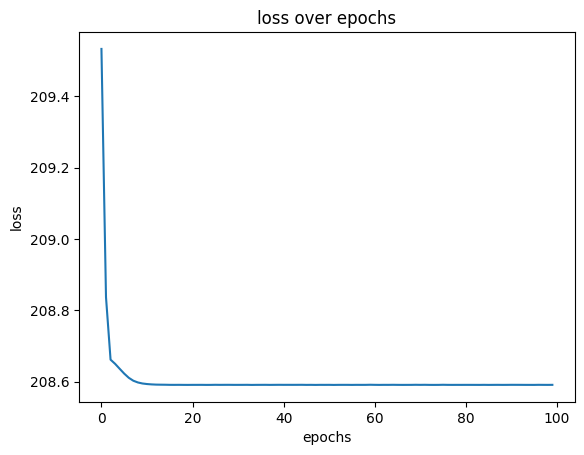

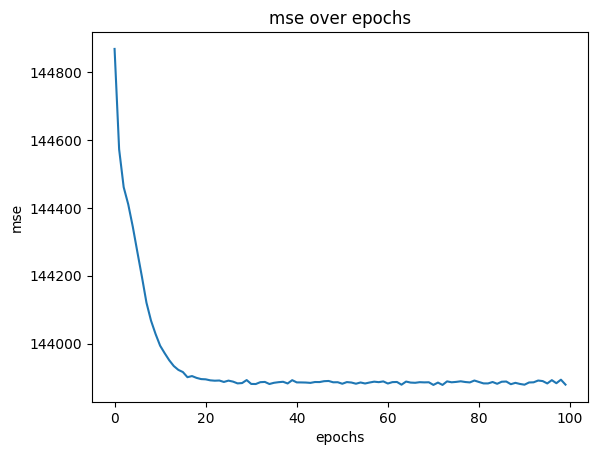

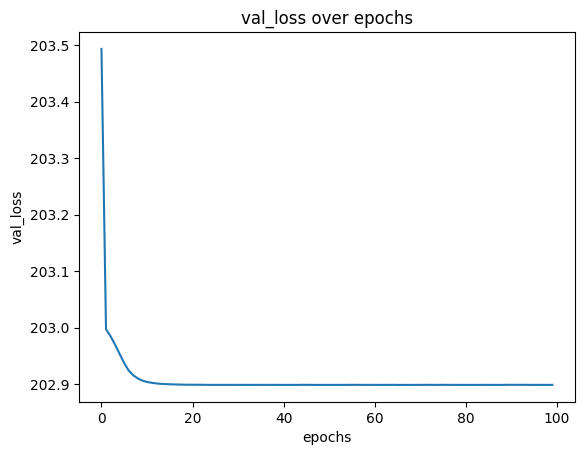

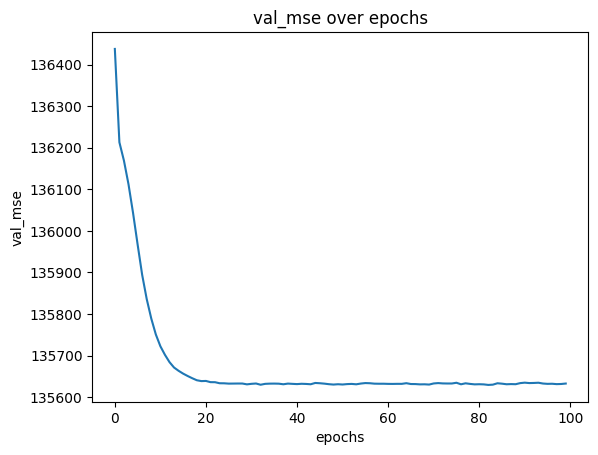

In [54]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [55]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 [==============================] - 1s 4ms/step - loss: 197.0105 - mse: 135657.4062
Mean absolute error:  197.01051330566406


In [56]:
mean_absolute_error(ytest, model.predict(xtest))

205/205 [==============================] - 1s 4ms/step


197.01051606307522

In [57]:
rmse = np.sqrt(mean_squared_error(ytest, model.predict(xtest)))

205/205 [==============================] - 1s 4ms/step


In [58]:
rmse

368.31690502589737

In [59]:
r2 = r2_score(ytest,model.predict(xtest))

205/205 [==============================] - 1s 4ms/step


In [60]:
r2

-0.39265933459137026

In [61]:
pickle_out=open("SolarNN.pkl","wb")
pickle.dump(model,pickle_out)
pickle_out.close()